This example will demonstrate how to use the randomization inference tools to analyze the results of a two variant A/B test, where the primary metric is continuous (e.g. dollars spent).  We'll first look at an example where the distributions of the continuous metric in both the control and treatment group are nicely behaved.  Here, conventional techniques like a t-test are sufficient.  We'll compare the application of the t-test to the randomization inference results.  

In a second example, we'll look at data from an experiment where the outcome metric is heavily skewed by zeros (zero inflated).  In this case, the usual t-test approach is not applicable.  Instead, we'll use the randomization inference tools to look at the experiment results without needing to make any parametric assumptions about our data.  

In [1]:
import sys
import pandas as pd

In [13]:
import scipy.stats as stats
import numpy as np

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style

In [18]:
style.use('fivethirtyeight')

In [2]:
# For now, this is a simple way to import the tools we need.
# Be sure to update the path to point to where the relevant code is stored on your machine
# TBD on eventually making this importable
sys.path.append('../../../ab_testing_utils/')

In [3]:
import skewed_metric_utils
import sim_utils

### Conventional example

First, we need to simulate some data.  We can use some of the pre-built tools in sim_utils.  

Here, we'll assume that we're looking at the results of a two variant A/B tes.  Furthemore, we'll assume that:

1. took place over the course of 3 weeks (3 * 7 = 21 days)  
2. On average, we had about 300 eligible units per day that could be assigned to either treatment or control 
3. The assignment to treatment or control is even. i.e. the probability of being assigned to the control group is 50%
4. Our primary metric here is dollars spent per unit
5. In the control group, we'll assume that the mean dollars spent per unit is \\$1,000.  In the treatment group, we'll assume that the mean is \\$1,010, i.e. the treatment really did have a positive impact.  

To make this simple, we'll just assume that the dollars spent in each group follows a normal distribution, centered on the mean. This means that the mean dollars spent is an appropriate test statistic here.  

In [159]:
daily_num_observations = 300
number_of_days_for_experiment = 3 * 7
p_vals = "equal"
group_col = 'group'

In [160]:
simulate_data = sim_utils.SimulateSkewedContinuous()

In [161]:
df_sim = simulate_data.simulate_expected_daily_visitors(number_of_days_for_experiment=number_of_days_for_experiment, daily_num_observations=daily_num_observations)

In [162]:
df_sim = simulate_data.assign_randomly(df=df_sim, p_vals=p_vals, group_col=group_col)

In [163]:
df_sim.head()

,day,units,group
0,0,1,treatment_1
1,0,1,treatment_1
2,0,1,treatment_1
3,0,1,control
4,0,1,control


In [164]:
def simulate_normal_continuous_outcomes(df: pd.DataFrame, loc: float = 0, scale: float = 1, outcome_col_name: str = 'outcome', rounding: int = 3) -> pd.DataFrame:
    
    outcomes_ = []
    df_ = df.copy()
    
    for d_ in df_['day'].unique():
        num_samples = df_.query("day=='{0}'".format(d_))['units'].sum()
        r = list(stats.norm.rvs(size=num_samples, loc=loc, scale=scale))
        outcomes_ = outcomes_ + r
    
    df_[outcome_col_name] = outcomes_
    df_[outcome_col_name] = df_[outcome_col_name].apply(lambda x: np.round(x, rounding))
    
    return df_

In [168]:
df_control = simulate_normal_continuous_outcomes(df=df_sim.query("group=='control'"), loc=1000, scale=200)
df_treatment = simulate_normal_continuous_outcomes(df=df_sim.query("group=='treatment_1'"), loc=1010, scale=200)

In [169]:
df_norm = pd.concat([df_control, df_treatment])

In [170]:
df_norm.head()

,day,units,group,outcome
3,0,1,control,1196.521
4,0,1,control,964.529
7,0,1,control,1014.538
9,0,1,control,1203.819
10,0,1,control,804.948


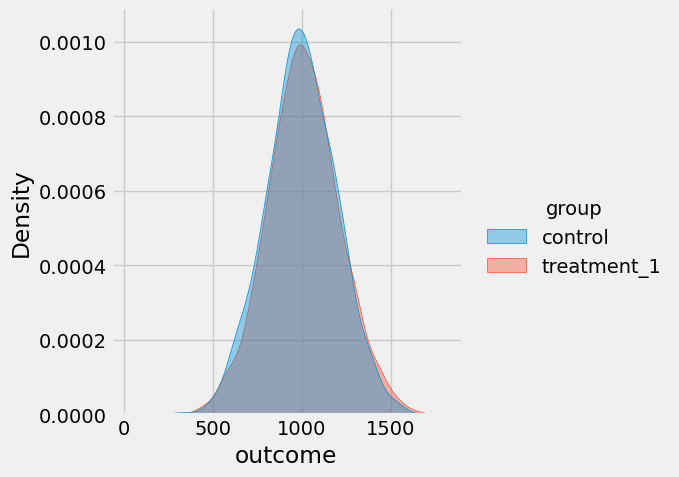

In [171]:
sns.displot(df_norm, x="outcome", hue="group", kind="kde", fill=True, alpha=0.4)

In [172]:
# So these are nice and simple 
# This looks about like what we'd expect from the relatively large sample we drew
df_norm.groupby('group')['outcome'].describe(percentiles=[0.25, 0.5, 0.75, 0.9])

,count,mean,std,min,25%,50%,75%,90%,max
group,,,,,,,,,
control,3170.0,995.254490,201.051477,140.282,863.54350,992.9335,1132.5105,1250.5655,1684.707
treatment_1,3064.0,1008.079551,202.864663,334.355,875.19425,1002.3590,1136.3775,1274.3483,1672.285


In [173]:
# So what happens if we run a conventional t-test on this?
# In this case, we know that the data generating process in both the treatment and control groups have the same variance.  In general though, we won't know this, so we won't assume it
stats.ttest_ind(a=df_norm.query("group=='control'")['outcome'], b=df_norm.query("group=='treatment_1'")['outcome'], equal_var=False)

TtestResult(statistic=-2.506405466935819, pvalue=0.012221882951990259, df=6220.502240041984)

In [174]:
# So the t-test (correctly) indicates a statistically significant difference in the means between the two groups.  
# In this case, the treatment mean is statistically significantly larger than the control group mean

In [175]:
# How about if we did the same thing with randomization inference? 
test_mean_difference_normal_dist = skewed_metric_utils.RandomizationInference()

Running randomization inference...


  0%|          | 0/1000 [00:00<?, ?it/s]

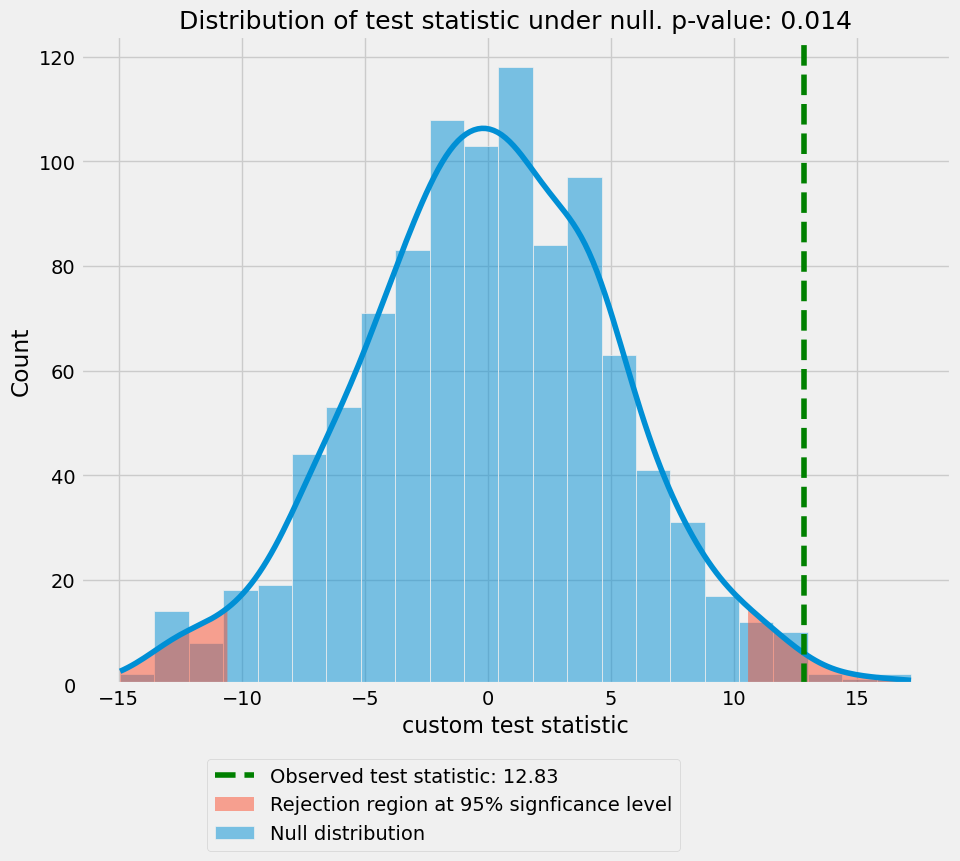

In [176]:
test_mean_difference_normal_dist.experimental_analysis(df=df_norm, 
                                                       outcome_column_name='outcome', 
                                                       treatment_column_name='group', 
                                                       treatment_name='treatment_1', 
                                                       control_name='control', 
                                                       sample_with_replacement=True)

In [ ]:
# So the co